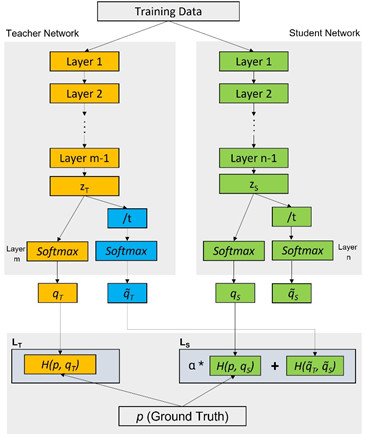
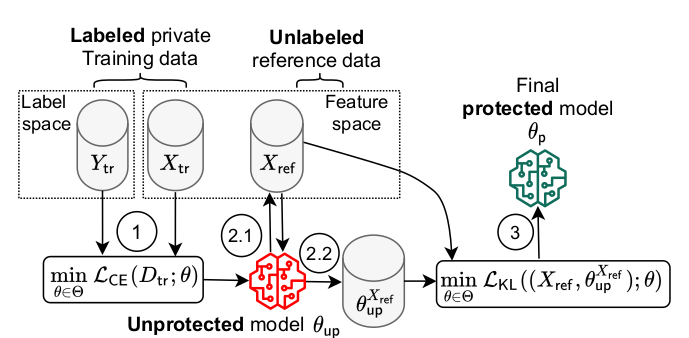

# Import dependencies + load data

In [2]:
#import
from torch import nn,optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets

from torchvision.datasets import CIFAR10, CIFAR100
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

In [6]:
private_data_len=10000
ref_data_len=10000
te_len=5000
val_len=5000
attack_tr_len=10000
attack_te_len=10000

batch_size = 1

tr_frac=0.5 # we use 50% of private data as the members to train MIA model
val_frac=0.25 # we use 25% of private data as the members to validate MIA model
te_frac=0.25 # we use 25% of private data as the members to test MIA model

dataset = CIFAR10(root='./data', download=True, transform=transform)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print("Total number of data: ", len(data_loader))


Files already downloaded and verified
Total number of data:  50000


torch.Size([1, 3, 32, 32])


# Building model

In [25]:
class VariablePurchase(nn.Module):
    def __init__(self,input_size=600, layer_sizes=[1024, 512, 256, 128], num_classes=100):
        super(VariablePurchase, self).__init__()
        
        self.layers=[]
        if len(layer_sizes):
            self.layers.append(nn.Linear(input_size, layer_sizes[0]))
            self.layers.append(nn.Tanh())
            for i in range(len(layer_sizes)-1):
                self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
                self.layers.append(nn.Tanh())
    #         self.features = nn.Sequential(nn.ModuleList(self.layers))
            self.features=nn.Sequential(*self.layers)
            self.classifier=nn.Linear(layer_sizes[len(layer_sizes)-1],num_classes)
        else:
            self.classifier=nn.Linear(input_size,num_classes)

    def forward(self,x):
        try:
            hidden_out = self.features(x)
        except:
            hidden_out = x
        return self.classifier(hidden_out),hidden_out

class PurchaseClassifier(nn.Module):
    def __init__(self,num_classes=100):
        super(PurchaseClassifier, self).__init__()

        self.features = nn.Sequential(
            nn.Linear(600,1024),
            nn.Tanh(),
            nn.Linear(1024,512),
            nn.Tanh(),
            nn.Linear(512,256),
            nn.Tanh(),
        )
        self.classifier = nn.Linear(256,num_classes)
        
    def forward(self,x):
        hidden_out = self.features(x)
        logits=self.classifier(hidden_out)

        return logits, hidden_out


class InferenceAttack_HZ(nn.Module):
    def __init__(self,num_classes):
        self.num_classes=num_classes
        super(InferenceAttack_HZ, self).__init__()
        self.features=nn.Sequential(
            nn.Linear(100,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,64),
            nn.ReLU(),
            )

        self.labels=nn.Sequential(
           nn.Linear(num_classes,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            )
        self.combine=nn.Sequential(
            nn.Linear(64*2,512),
            
            nn.ReLU(),
            nn.Linear(512,256),
            
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,1),
            )
        for key in self.state_dict():
            if key.split('.')[-1] == 'weight':    
                nn.init.normal_(self.state_dict()[key], std=0.01)
                
            elif key.split('.')[-1] == 'bias':
                self.state_dict()[key][...] = 0
        self.output= nn.Sigmoid()
    def forward(self,x1,x2,l):

        out_x1 = self.features(x1)
        
        out_l = self.labels(l)

        is_member =self.combine( torch.cat((out_x1,out_l),1))
        
        
        return self.output(is_member)
